#  Initializations

In [2]:
%matplotlib inline
%config IPCompleter.greedy = True

from __future__ import division, print_function, unicode_literals


from sklearn.metrics import cohen_kappa_score,confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV, ShuffleSplit, learning_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn import tree, neighbors, linear_model
from sklearn import neighbors
from IPython.display import Image

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz 
import itertools



le = LabelEncoder()
ohe = OneHotEncoder()



## Data Cleaning & Preparation

In [4]:
df = pd.read_csv("raw.csv")

# Selecting 23 attributes 
df = df.loc[:,["Department", "GEO","Role","Will_Relocate","Critical","Percent_Remote","last_evaluation","number_project",
                   "average_montly_hours","time_spend_company","Work_accident","promotion_last_5years","salary","Gender",
                   "LinkedIn_Hits","Emp_Identity","Emp_Role","Emp_Position","Emp_Title","Sensor_StepCount",
                   "Sensor_Heartbeat(Average/Min)","Sensor_Proximity(1-highest/10-lowest)","left_Company"]]

# Missing Values
df['Critical'] = df['Critical'].replace(np.nan,0)

# Variable Type Cleaning 

for column in ['left_Company', 'Department', 'GEO', 'Will_Relocate', 'Critical', 'promotion_last_5years', 'Gender',
               'Emp_Identity', 'Emp_Role', 'Emp_Position', 'Emp_Title']:
    df[column] = df[column].astype('category')
    
    

    
    
    
# Categorical variables that need conversion 
# Ordinal Conversion
salary_mapper = {'low':0, 'medium':1, 'high':2}
role_mapper = {'Level 1':0, 'Level 2-4':1, 'Manager':2, 'Senior Manager':3, 'Director':4, 'Senior Director':5, 'VP':6}

df.loc[:,'salary'] = df.loc[:,'salary'].replace(salary_mapper)
df['Role'] = df['Role'].replace(role_mapper)



# Binary Conversion with Label Encoder
df['Gender'] = le.fit_transform(df['Gender'])
df['Department'] = le.fit_transform(df['Department'])  # added
df['GEO'] = le.fit_transform(df['GEO']) 

# Categorical Conversion with OneHotEncoder
labels = ohe.fit_transform(df.iloc[:,:2]).toarray()

header=['Finance', 'HR', 'IT', 'Operations', 'Sales', 'Warehouse', 
        'Australia', 'China', 'Colombia', 'France', 'Japan', 'Korea', 'Turkey', 'UK', 'US']

df_ohe = pd.DataFrame(labels, columns = header)
df = df.iloc[:,2:]
df = pd.concat([df_ohe,df],axis=1)


# Exluding Warehouse & Colombia to reduce multicollinearity (n-1)
df.drop(['Warehouse','Colombia'], axis=1, inplace=True)



#Processed Data
#df.to_csv("processed.csv")   

# Features and Target
x = df.iloc[:,0:33]
y = df['left_Company']

C:\Users\kwaku\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Exploring

In [7]:
#Target Variable 

unique, counts = np.unique(y, return_counts=True) 
print("The frequency of instances per class is: " , dict(zip(unique, counts)))
print("The names of the two distinct classes are: ", np.unique(y)) 

print("The ratio of the classes are : \n", df.left_Company.value_counts(1))


The frequency of instances per class is:  {0: 11428, 1: 3571}
The names of the two distinct classes are:  [0 1]
The ratio of the classes are : 
 0    0.761917
1    0.238083
Name: left_Company, dtype: float64


<Figure size 1080x1440 with 0 Axes>

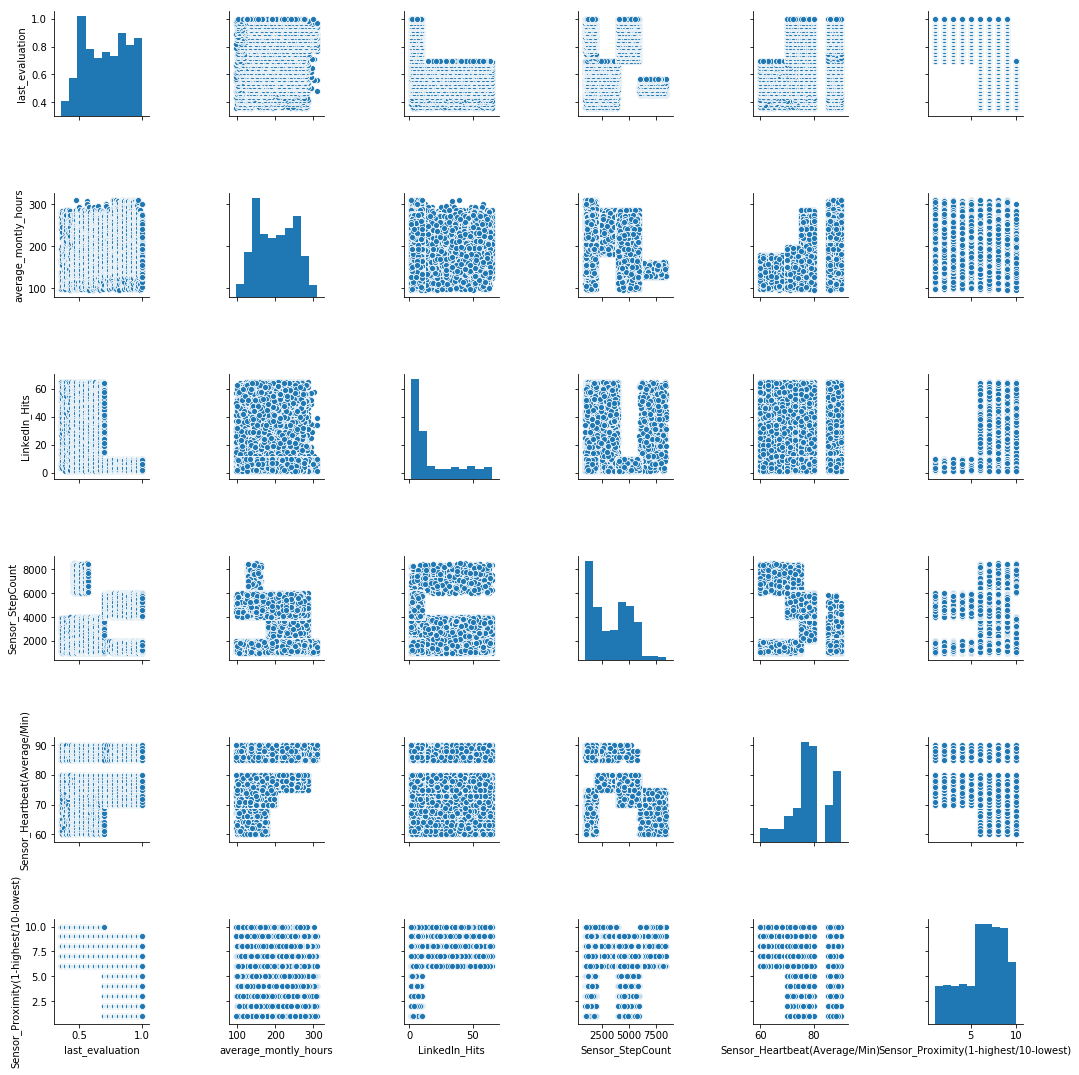

In [148]:
# Histograms
cols = ['last_evaluation', 'average_montly_hours', 'LinkedIn_Hits', 'Sensor_StepCount', 'Sensor_Heartbeat(Average/Min)', 'Sensor_Proximity(1-highest/10-lowest)']  

fig = plt.figure(figsize = (15,20))
sns.pairplot(df[cols]) 
plt.tight_layout() 

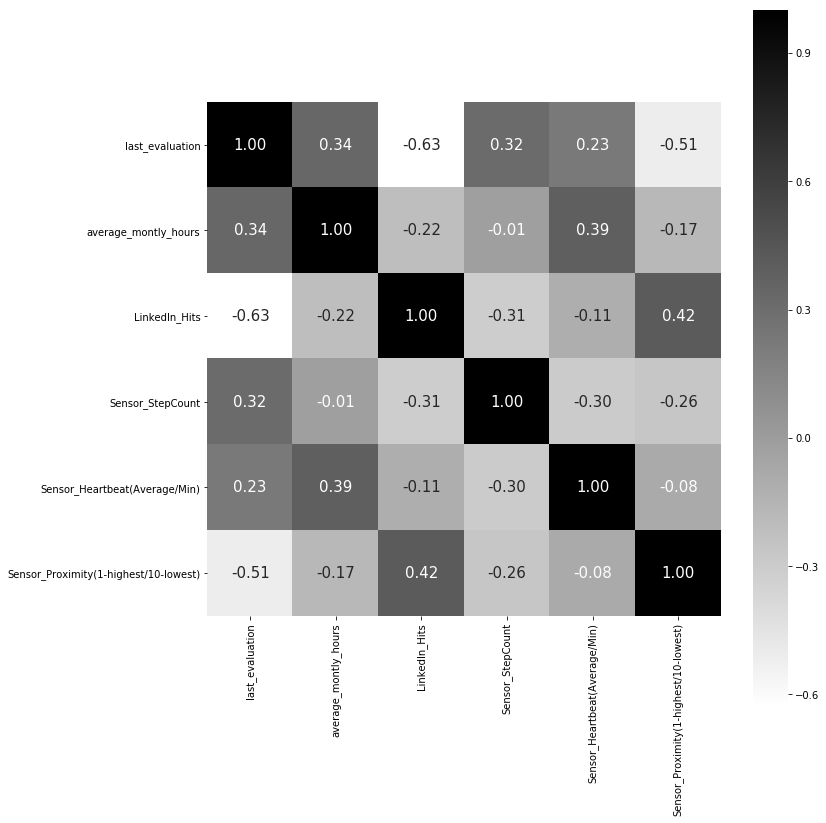

In [149]:
# Correlations

cm = np.corrcoef(df[cols].values.T) 
fig = plt.figure(figsize = (12,12)) 

hm = sns.heatmap(cm,                
                 cbar=True,         
                 annot=True,        
                 square=True,       
                 fmt='.2f',         
                 annot_kws={'size': 15}, 
                 yticklabels=cols,  
                 xticklabels=cols, 
                 cmap='binary')

plt.tight_layout()

# plt.savefig('correlation_coefficient.png', dpi=300)

plt.show()



## Function Definitions

In [5]:
# Learning Curve function definition 

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'recall')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt




# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Modeling

In [3]:
# Train, Validation, Test split
X_train, X_valtest, y_train, y_valtest = train_test_split(x, y, test_size=0.4, random_state=11, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=11, stratify=y_valtest)


## Decision Tree

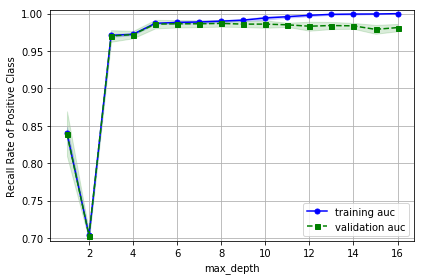

In [8]:
# Fitting Curve - Decision Tree 

             
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16]

# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( estimator=DecisionTreeClassifier(random_state=11), X=X_train, y=y_train,
                                             param_name="max_depth", param_range=param_range, cv=5, scoring="recall")  

# Cross validation statistics for training and testing data 
train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1)   
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot train accuracy means of cross-validation for all the parameters in param_range
plt.plot(param_range, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training auc')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, 
                     train_mean + train_std,
                     train_mean - train_std, 
                     alpha=0.15, color='blue')

# Plot test accuracy means of cross-validation for all the parameters in param_range
plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation auc')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()

plt.legend(loc='lower right')
plt.xlabel("max_depth")  
plt.ylabel('Recall Rate of Positive Class') 
plt.ylim([min(min(test_mean), min(train_mean))*0.99, max(max(test_mean), max(train_mean))*1.005]) # y limits in the plot
plt.tight_layout()

# plt.savefig('Fitting_graph_LR.png', dpi=300)

plt.show()           



In [9]:
#Gridsearch CV 

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=11),
                 param_grid=[{'max_depth': [5, 6, 7, 8, 9,10, None],
                            'criterion':['gini','entropy'], 
                             'min_samples_leaf':np.arange(0.004,0.006,0.0005),
                             'min_samples_split':np.arange(0.006,0.012,0.0005),
                             'min_impurity_decrease':[0.0002,0.00025,0.001, 0.0003]}],
                 scoring='recall', 
                 cv=5,
                 n_jobs = 5)

gs_dt = gs_dt.fit(X_train,y_train)
print(gs_dt.best_score_)
print(gs_dt.best_params_)
print(gs_dt.best_estimator_)

0.9873993659167609
{'criterion': 'gini', 'max_depth': 5, 'min_impurity_decrease': 0.0002, 'min_samples_leaf': 0.005000000000000001, 'min_samples_split': 0.006}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0002, min_impurity_split=None,
            min_samples_leaf=0.005000000000000001, min_samples_split=0.006,
            min_weight_fraction_leaf=0.0, presort=False, random_state=11,
            splitter='best')


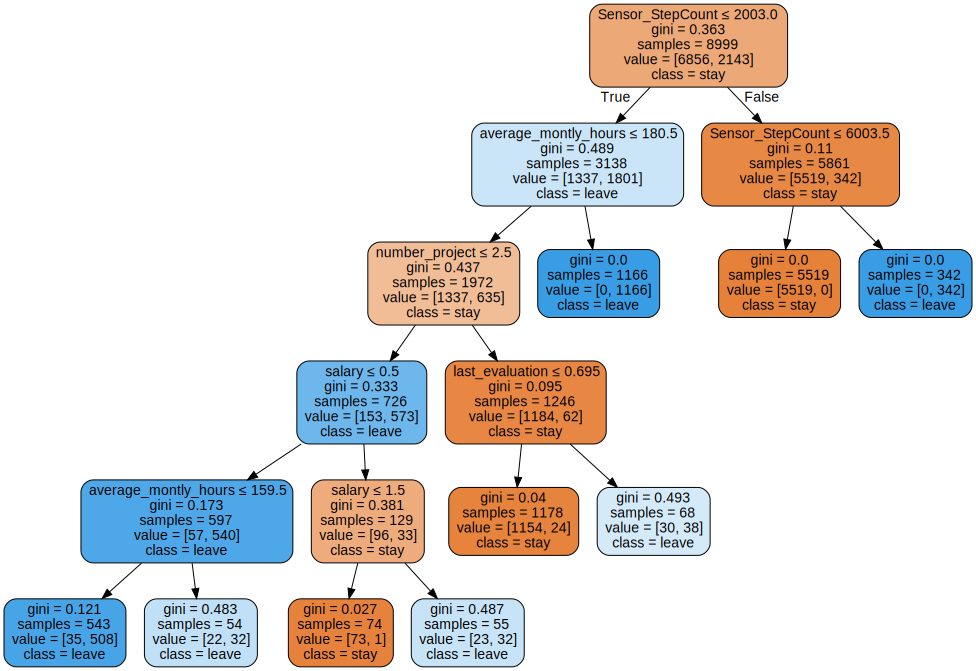

In [6]:
# Fitting with outcome from gridsearch


dt1 = tree.DecisionTreeClassifier(criterion = 'gini', 
                                   max_depth = 5, 
                                   min_impurity_decrease = 0.0002,
                                   min_samples_leaf = 0.005,
                                   min_samples_split = 0.006,
                                   random_state=11)
dt1 = dt1.fit(X_train, y_train)
dot_data1 = tree.export_graphviz(dt1, out_file=None, 
                         feature_names=list(X_train),  
                         class_names=['stay','leave'], 
                         filled=True, rounded=True,
                         special_characters=True)

# Plotting the tree
graph = graphviz.Source(dot_data1) 
#graph.render('hr_tree1')
graph

In [121]:
# Generalization performance with CV

acc_score = cross_val_score(dt1, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.4f +/- %.4f' % (np.mean(acc_score),
                                      np.std(acc_score)))
recall_score = cross_val_score(dt1, X_train, y_train,  
                         scoring='recall', cv=5)
print('CV recall: %.4f +/- %.4f' % (np.mean(recall_score),
                                      np.std(recall_score)))
precision_score = cross_val_score(dt1, X_train, y_train,  
                         scoring='precision', cv=5)
print('CV precision: %.4f +/- %.4f' % (np.mean(precision_score),
                                      np.std(precision_score)))
roc_score = cross_val_score(dt1, X_train, y_train,  
                         scoring='roc_auc', cv=5)
print('CV ROC score: %.4f +/- %.4f' % (np.mean(roc_score),
                                      np.std(roc_score)))
f1_score = cross_val_score(dt1, X_train, y_train,  
                         scoring='f1', cv=5)
print('CV F1 score: %.4f +/- %.4f' % (np.mean(f1_score),
                                      np.std(f1_score)))

CV accuracy: 0.9848 +/- 0.0024
CV recall: 0.9874 +/- 0.0038
CV precision: 0.9506 +/- 0.0078
CV ROC score: 0.9968 +/- 0.0011
CV F1 score: 0.9687 +/- 0.0048


Confusion matrix, without normalization
[[2245   41]
 [  11  703]]
Normalized confusion matrix
[[0.9821 0.0179]
 [0.0154 0.9846]]


<Figure size 432x288 with 0 Axes>

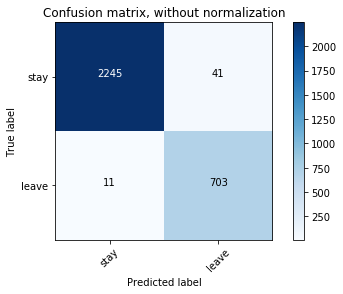

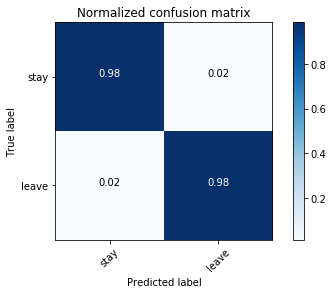


Other accuracy report:
             precision    recall  f1-score   support

       Stay       1.00      0.98      0.99      2286
      Leave       0.94      0.98      0.96       714

avg / total       0.98      0.98      0.98      3000



In [12]:
# More metrics 

#Confusion Matrix


y_pred1 = dt1.predict(X_valid)

cnf_matrix1 = confusion_matrix(y_valid, y_pred1)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.clf()
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['stay','leave'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['stay','leave'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

print('\nOther accuracy report:\n'+ classification_report(y_valid, y_pred1, target_names=['Stay','Leave']))

### k-NN

In [11]:
# Feature Selection for kNN

etc= ExtraTreesClassifier()
etc = etc.fit(X_train, y_train) 

#print(etc.feature_importances_)


model = SelectFromModel(etc, prefit=True)
X_new = model.transform(X_train)
X_train_new=pd.DataFrame(X_new)

X_valid_new=model.transform(X_valid)
X_valid_new=pd.DataFrame(X_valid_new)

X_test_new=model.transform(X_test)
X_test_new=pd.DataFrame(X_test_new)



# Scaling for k-NN

sc = StandardScaler()
sc.fit(X_train_new)
X_train_std = sc.transform(X_train_new)
X_test_std = sc.transform(X_test_new)
X_valid_std = sc.transform(X_valid_new)

X_train_std = pd.DataFrame(X_train_std)
X_valid_std = pd.DataFrame(X_valid_std)
X_test_std = pd.DataFrame(X_test_std)





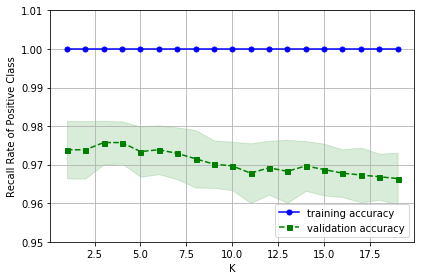

In [14]:
# Fitting Curve fo r base knn

np.random.seed(11) 

param_range = range(1,20)

# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( 
                estimator=neighbors.KNeighborsClassifier(p=2, metric='minkowski',weights="distance",algorithm='auto') ,
                X=X_train_std, 
                y=y_train, 
                param_name="n_neighbors", 
                param_range=param_range,
                cv=5,   
                scoring="recall") 


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1)   
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot train accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('K')
plt.ylabel('Recall Rate of Positive Class')
plt.ylim([0.95, 1.01]) 
plt.tight_layout()
plt.show()           


In [153]:
# Grid Search CV

gs_knn = GridSearchCV(estimator=neighbors.KNeighborsClassifier(metric='minkowski'),
                  param_grid=[{'n_neighbors': range(1,10),
                               'weights':['uniform','distance'],
                               'p':[1,2]}],
                  scoring='recall',
                  cv=5,
                  n_jobs=4)
gs_knn = gs_knn.fit(X_train_std, y_train)  

print(gs_knn.best_score_)
print(gs_knn.best_params_)
print(gs_knn.best_estimator_)

0.9790013285212128
{'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')


In [12]:
# Fitting with outcome from Gridsearch

knn = neighbors.KNeighborsClassifier(n_neighbors=4, p=2, metric='minkowski',weights="distance",algorithm='auto') # changed k
knn = knn.fit(X_train_std, y_train) 
    
y_pred = knn.predict(X_valid_std)
y_pred_insample = knn.predict(X_train_std)


In [122]:
# Generalization Performance with Cross Validation

acc_score = cross_val_score(knn, X_train_std, y_train,   
                         scoring='accuracy', cv=5)
print('CV accuracy: %.4f +/- %.4f' % (np.mean(acc_score),
                                      np.std(acc_score)))
recall_score = cross_val_score(knn, X_train_std, y_train,  
                         scoring='recall', cv=5)
print('CV recall: %.4f +/- %.4f' % (np.mean(recall_score),
                                      np.std(recall_score)))
precision_score = cross_val_score(knn, X_train_std, y_train,  
                         scoring='precision', cv=5)
print('CV precision: %.4f +/- %.4f' % (np.mean(precision_score),
                                      np.std(precision_score)))
roc_score = cross_val_score(knn, X_train_std, y_train,  
                         scoring='roc_auc', cv=5)
print('CV ROC score: %.4f +/- %.4f' % (np.mean(roc_score),
                                      np.std(roc_score)))
f1_score = cross_val_score(knn, X_train_std, y_train,  
                         scoring='f1', cv=5)
print('CV F1 score: %.4f +/- %.4f' % (np.mean(f1_score),
                                      np.std(f1_score)))

CV accuracy: 0.9858 +/- 0.0029
CV recall: 0.9757 +/- 0.0055
CV precision: 0.9650 +/- 0.0089
CV ROC score: 0.9896 +/- 0.0030
CV F1 score: 0.9703 +/- 0.0061


Confusion matrix, without normalization
[[2262   24]
 [  18  696]]
Normalized confusion matrix
[[0.9895 0.0105]
 [0.0252 0.9748]]


<Figure size 432x288 with 0 Axes>

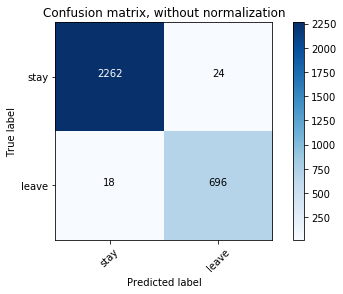

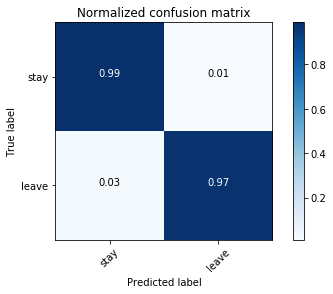


Other accuracy report:
             precision    recall  f1-score   support

       Stay       0.99      0.99      0.99      2286
      Leave       0.97      0.97      0.97       714

avg / total       0.99      0.99      0.99      3000



In [18]:
# More metrics 

#Confusion Matrix


y_pred1 = knn.predict(X_valid_std)

cnf_matrix1 = confusion_matrix(y_valid, y_pred1)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.clf()
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['stay','leave'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['stay','leave'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Added other report
print('\nOther accuracy report:\n'+ classification_report(y_valid, y_pred1, target_names=['Stay','Leave']))

## Logistic Regression

In [8]:
X_train_log = X_train.copy(deep=True)
X_valid_log = X_valid.copy(deep=True)
X_test_log = X_test.copy(deep=True)


X_train_log['LinkedIn_Hits'] = np.log(X_train_log.loc[:,'LinkedIn_Hits'])
X_train_log['Sensor_StepCount'] = np.log(X_train_log.loc[:,'Sensor_StepCount'])
X_train_log['Sensor_Heartbeat(Average/Min)'] = np.log(X_train_log.loc[:,'Sensor_Heartbeat(Average/Min)'])
X_valid_log['LinkedIn_Hits'] = np.log(X_valid_log.loc[:,'LinkedIn_Hits'])
X_valid_log['Sensor_StepCount'] = np.log(X_valid_log.loc[:,'Sensor_StepCount'])
X_valid_log['Sensor_Heartbeat(Average/Min)'] = np.log(X_valid_log.loc[:,'Sensor_Heartbeat(Average/Min)'])
X_test_log['LinkedIn_Hits'] = np.log(X_test_log.loc[:,'LinkedIn_Hits'])
X_test_log['Sensor_StepCount'] = np.log(X_test_log.loc[:,'Sensor_StepCount'])
X_test_log['Sensor_Heartbeat(Average/Min)'] = np.log(X_test_log.loc[:,'Sensor_Heartbeat(Average/Min)'])



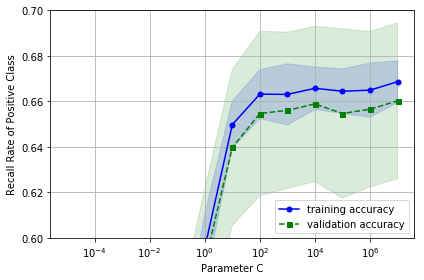

In [155]:
# Fitting Curve

np.random.seed(11) 


param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000, 10000000]


# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( 
                estimator=LogisticRegression(random_state=None), #Build Logistic Regression Models
                X=X_train_log, 
                y=y_train, 
                param_name="C", 
                param_range=param_range,
                cv=5,     
                scoring="recall", 
                n_jobs=4) 

# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) 
train_std = np.std(train_scores, axis=1)   
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot train accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Recall Rate of Positive Class')
plt.ylim([0.6, 0.7]) 
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           #display the figure



In [66]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 7, 15)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

 
gs_log  = GridSearchCV(LogisticRegression(), hyperparameters, cv=5,scoring='recall') #GridSearchCV  # changed scoring to recall
gs_log.fit(X_train_log, y_train) # Fit model

log_model = gs_log.best_estimator_ # best performance

print (gs_log.best_score_, gs_log.best_params_) #parameters that gave the best performance
print(log_model)

0.6616956579109695 {'C': 31622.776601683792, 'penalty': 'l2'}
LogisticRegression(C=31622.776601683792, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [9]:
# Fitting with best parameters from grid search

logit = LogisticRegression(C=31622.776601683792, penalty = 'l2')

logit = logit.fit(X_train_log, y_train)

In [184]:
np.set_printoptions(suppress=True)
print(logit.coef_)

[[-0.01  0.01  0.07 -0.02 -0.04 -0.34 -0.06 -0.36 -0.18 -0.29 -0.37 -0.14
  -0.17 -0.05 -0.01  0.74 14.47 -4.   -0.56 -0.    0.11 -1.44  2.51 -0.34
  -0.11 -0.09 -1.17 -1.21 -1.1  -0.97 -0.93 -4.53 -0.04]]


In [123]:
# Generalization performance


acc_score = cross_val_score(logit, X_train_log, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.4f +/- %.4f' % (np.mean(acc_score),
                                      np.std(acc_score)))
recall_score = cross_val_score(logit, X_train_log, y_train,  
                         scoring='recall', cv=5)
print('CV recall: %.4f +/- %.4f' % (np.mean(recall_score),
                                      np.std(recall_score)))
precision_score = cross_val_score(logit, X_train_log, y_train,  
                         scoring='precision', cv=5)
print('CV precision: %.4f +/- %.4f' % (np.mean(precision_score),
                                      np.std(precision_score)))
roc_score = cross_val_score(logit, X_train_log, y_train,  
                         scoring='roc_auc', cv=5)
print('CV ROC score: %.4f +/- %.4f' % (np.mean(roc_score),
                                      np.std(roc_score)))
f1_score = cross_val_score(logit, X_train_log, y_train,  
                         scoring='f1', cv=5)
print('CV F1 score: %.4f +/- %.4f' % (np.mean(f1_score),
                                      np.std(f1_score)))

CV accuracy: 0.8751 +/- 0.0109
CV recall: 0.6617 +/- 0.0364
CV precision: 0.7799 +/- 0.0194
CV ROC score: 0.9167 +/- 0.0115
CV F1 score: 0.7157 +/- 0.0289


Confusion matrix, without normalization
[[2132  154]
 [ 233  481]]
Normalized confusion matrix
[[0.9326 0.0674]
 [0.3263 0.6737]]


<Figure size 432x288 with 0 Axes>

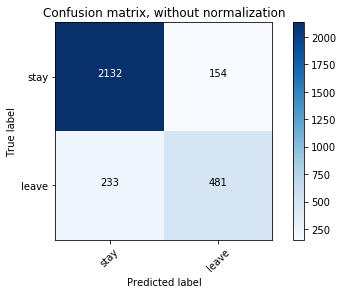

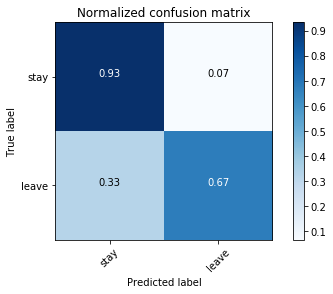


Other accuracy report:
             precision    recall  f1-score   support

       Stay       0.90      0.93      0.92      2286
      Leave       0.76      0.67      0.71       714

avg / total       0.87      0.87      0.87      3000



In [68]:
#Confusion Matrix


y_pred1 = logit.predict(X_valid_log)

cnf_matrix1 = confusion_matrix(y_valid, y_pred1)
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.clf()
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['stay','leave'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['stay','leave'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


print('\nOther accuracy report:\n'+ classification_report(y_valid, y_pred1, target_names=['Stay','Leave']))


## ROC Comparison of Algorithms -  input other classifers before you run

5-fold cross validation:

ROC AUC: 1.00 (+/- 0.00) [tree]
ROC AUC: 0.99 (+/- 0.00) [knn]
ROC AUC: 0.92 (+/- 0.01) [logit]


C:\Users\knigh\Anaconda3\lib\site-packages\matplotlib\legend.py:640: UserWarning: Unrecognized location " lower right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


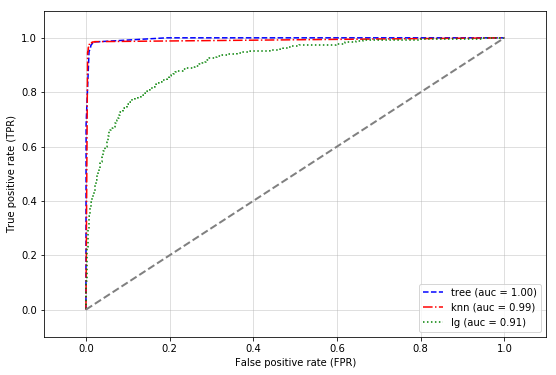

In [13]:
# Decision Tree Classifier
clf1 = dt1

# kNN Classifier
clf2 = knn

# Logistic Regression Classifier
clf3 = logit

# Label the classifiers
clf_labels = ['Decision tree', 'KNN', 'Logistic regression']
all_clf = [clf1, clf2, clf3]

print('5-fold cross validation:\n')



#Decision Tree
scores = cross_val_score(estimator=clf1,  
                             X=X_train,
                             y=y_train,
                             cv=5,
                             scoring='roc_auc')
print("ROC AUC: %0.2f (+/- %0.2f) [%s]" #Print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), 'tree'))


#k-NN
scores = cross_val_score(estimator=clf2,  #Estimate AUC based on cross validation
                             X=X_train_std,
                             y=y_train,
                             cv=5,
                             scoring='roc_auc')
print("ROC AUC: %0.2f (+/- %0.2f) [%s]" #Print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), 'knn'))




#Logit
scores = cross_val_score(estimator=clf3,  #Estimate AUC based on cross validation
                             X=X_train_log,
                             y=y_train,
                             cv=5,
                             scoring='roc_auc')
print("ROC AUC: %0.2f (+/- %0.2f) [%s]" #Print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), 'logit'))





fig = plt.figure(figsize = (9,6)) # changed size

#Decision Tree

y_pred = clf1.fit(X_train,
                     y_train).predict_proba(X_valid)[:, 1] # Make predictions based on the classifiers
fpr, tpr, thresholds = roc_curve(y_true=y_valid, # Build ROC curve
                                     y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color='blue',
             linestyle= '--',
             label='%s (auc = %0.2f)' % ('tree', roc_auc))


#k-NN

y_pred = clf2.fit(X_train_std,
                     y_train).predict_proba(X_valid_std)[:, 1] # Make predictions based on the classifiers
fpr2, tpr2, thresholds2 = roc_curve(y_true=y_valid, # Build ROC curve
                                     y_score=y_pred)
roc_auc = auc(x=fpr2, y=tpr2)                # Compute Area Under the Curve (AUC) 
plt.plot(fpr2, tpr2,                         # Plot ROC Curve and create label with AUC values
             color='red',
             linestyle='-.',
             label='%s (auc = %0.2f)' % ('knn', roc_auc))





#Logit

y_pred = clf3.fit(X_train_log,
                     y_train).predict_proba(X_valid_log)[:, 1] # Make predictions based on the classifiers
fpr3, tpr3, thresholds3 = roc_curve(y_true=y_valid, # Build ROC curve
                                     y_score=y_pred)
roc_auc = auc(x=fpr3, y=tpr3)                # Compute Area Under the Curve (AUC) 
plt.plot(fpr3, tpr3,                         # Plot ROC Curve and create label with AUC values
             color='green',
             linestyle=':',
             label='%s (auc = %0.2f)' % ('lg', roc_auc))



plt.legend(loc=' lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)

plt.show()

In [14]:
print('FPRS of decision tree:')
print(fpr)
print('TPRS of decision tree:')
print(tpr)
print('ThresholdS of decision tree:')
print(thresholds)
print('\nFPRS of kNN:')
print(fpr2)
print('TPRS of kNN:')
print(tpr2)
print('ThresholdS of kNN:')
print(thresholds2)

FPRS of decision tree:
[0.00000000e+00 4.37445319e-04 7.43657043e-03 1.09361330e-02
 1.18110236e-02 1.79352581e-02 1.92913386e-01 2.05599300e-01
 1.00000000e+00]
TPRS of decision tree:
[0.         0.68207283 0.94957983 0.96218487 0.9719888  0.98459384
 1.         1.         1.        ]
ThresholdS of decision tree:
[2.         1.         0.93554328 0.59259259 0.58181818 0.55882353
 0.02037351 0.01351351 0.        ]

FPRS of kNN:
[0.         0.00393701 0.00393701 0.00437445 0.00437445 0.00524934
 0.00524934 0.00568679 0.00568679 0.00612423 0.00612423 0.00656168
 0.00656168 0.00743657 0.00743657 0.00787402 0.00787402 0.00918635
 0.00918635 0.01006124 0.01006124 0.01049869 0.01049869 0.01312336
 0.01312336 0.01487314 0.01487314 0.02055993 0.02055993 0.02974628
 1.        ]
TPRS of kNN:
[0.         0.93697479 0.94677871 0.94677871 0.94957983 0.94957983
 0.95798319 0.95798319 0.96358543 0.96358543 0.96918768 0.96918768
 0.97058824 0.97058824 0.9719888  0.9719888  0.97619048 0.97619048
 0.977

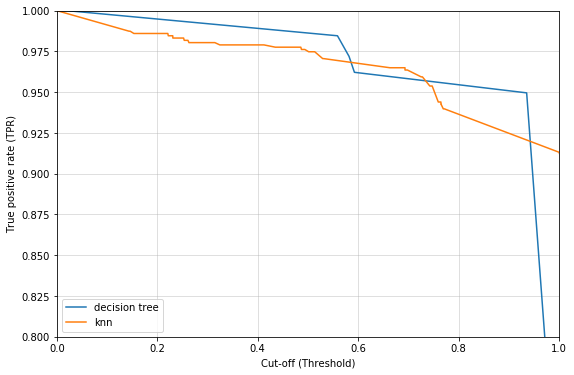

In [115]:
plt.figure(figsize = (9,6))
plt.plot(thresholds,tpr,label='decision tree')
plt.plot(thresholds2,tpr2,label='knn')
plt.xlim(0,1)
plt.ylim(0.8,1)
plt.grid(alpha=0.5)
plt.xlabel('Cut-off (Threshold)')
plt.ylabel('True positive rate (TPR)')
plt.legend(loc= 'lower left')

## Learning Curve of final model

<Figure size 648x432 with 0 Axes>

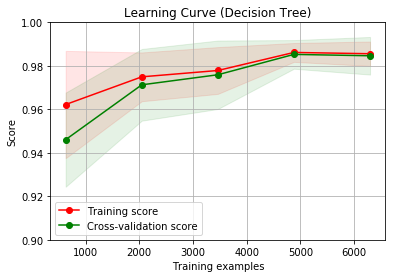

In [134]:
title = "Learning Curve (Decision Tree)" 

fig = plt.figure(figsize = (9,6))

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=11)
estimator = clf1

plot_learning_curve(estimator, title, X_train, y_train, (0.9, 1.00), cv=cv, n_jobs=4)
plt.legend(loc= 'lower left')
plt.show()

## Deployment

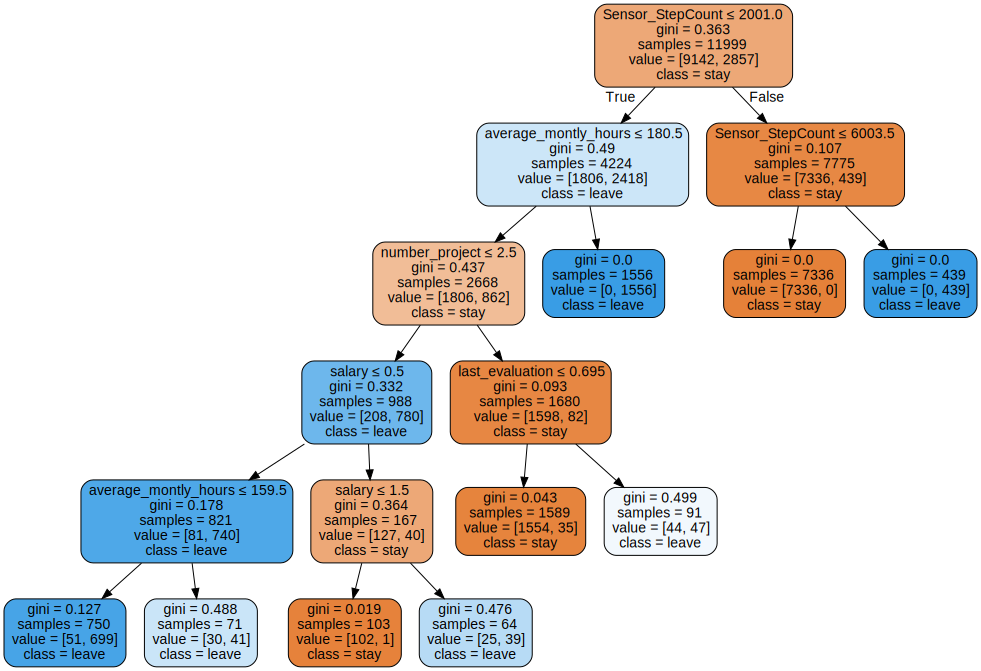

In [103]:
# Decision Tree

X_trainvalid = pd.concat([X_train, X_valid]) 

dt2 = tree.DecisionTreeClassifier(criterion = 'gini', 
                                   max_depth = 5, 
                                   min_impurity_decrease = 0.0002,
                                   min_samples_leaf = 0.005,
                                   min_samples_split = 0.006,
                                   random_state=11)

dt2 = dt2.fit(X_trainvalid, y_trainvalid)
dot_data2 = tree.export_graphviz(dt2, out_file=None, 
                         feature_names=list(X_trainvalid),  
                         class_names=['stay','leave'], 
                         filled=True, rounded=True,
                         special_characters=True)

# Plotting the tree
graph = graphviz.Source(dot_data2) 
graph


Confusion matrix, without normalization
[[2252   34]
 [  14  700]]
Normalized confusion matrix
[[0.9851 0.0149]
 [0.0196 0.9804]]


<Figure size 432x288 with 0 Axes>

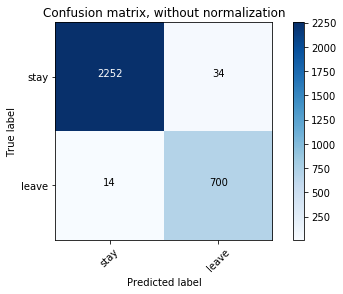

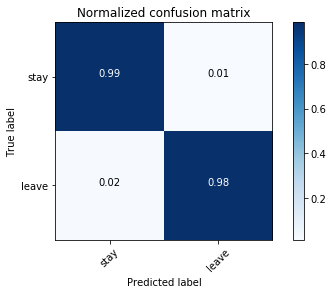


Other accuracy report:
             precision    recall  f1-score   support

       Stay       0.99      0.99      0.99      2286
      Leave       0.95      0.98      0.97       714

avg / total       0.98      0.98      0.98      3000



In [156]:
cutoff = thresholds[5] # choose the best cutoff from the list of thresholds
bestclf = dt2 # use the name of the best clasifier

y_pred_best = bestclf.predict_proba(X_test)[:, 1] # probability estimation
probdf = pd.DataFrame({"y_test": y_test,"prob":y_pred_best})
probdf = probdf.reset_index(drop=True) # reindex
probdf = probdf.sort_values('prob',ascending = 0) # sort the dataframe by probability descending
length = len(probdf[probdf.prob > cutoff]) # number of predicted positives

probdf["y_pred"]=1
probdf.loc[probdf["prob"] <= cutoff,"y_pred"]=0


num_tp = sum(probdf.y_test.iloc[:length])
num_fp = length - num_tp
num_fn = len(probdf[probdf.y_test == 1]) - num_tp
num_tn = len(probdf[probdf.y_test == 0]) - num_fp

# create an cnf matrix array
best_cnf_matrix = np.array([[num_tn,num_fp],[num_fn,num_tp]])
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.clf()
plt.figure()
plot_confusion_matrix(best_cnf_matrix, classes=['stay','leave'],
title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(best_cnf_matrix, classes=['stay','leave'], normalize=True,
title='Normalized confusion matrix')

plt.show()


print('\nOther accuracy report:\n'+ classification_report(probdf['y_test'], probdf["y_pred"], target_names=['Stay','Leave']))